# Amazon reviews sentiment analysis

In this notebook, we'll analyze the sentiment of amazon reviews on different products, mostly related to computers and electronics. We start by importing some necessary packages.

In [58]:
%matplotlib inline
import numpy as np #Linear algebra.  
import itertools # For combinations
import matplotlib.pyplot as plt # Plotting.
import re #Regular Expressions.
from textblob import TextBlob #Sentiment analysis.
import pandas as pd #Dataframes

#import nltk #Needed to download stopwords.
#nltk.download()

After this, we need to prepare the parameters of the matplotlib plotting library to get plots of a higher quality.

In [59]:
#Prepare matplotlib parameters.

from matplotlib import rcParams
rcParams['figure.figsize'] = (10, 6) # Size of plot
rcParams['figure.dpi'] = 150 #Dots per inch of plot
rcParams['lines.linewidth'] = 2 # Width of lines of the plot
rcParams['axes.facecolor'] = 'white' #Color of the axes
rcParams['font.size'] = 14 # Size of the text.
rcParams['patch.edgecolor'] = 'white' #Patch edge color.
rcParams['font.family'] = 'StixGeneral' #Font of the plot text.

With those preparations out of the way, we can start working on the reviews.

## 1. Preparing the data

First, we need to get the review data. This data is contained in a large text file, which contains a large number of reviews.

In [60]:
reviews = open("Computer.txt","r").read() #Open and read the text file.

This text data, however, is unbelievably messy. Since the analysis really won't work with the data like this, we need to clean it up. To do this, we define a function that cleans the text through several steps. These steps are:

1. Removing special symbols.
2. Replacing whitespaces  and newlines.
3. Separating the data into sentences.

These are done using the **re** Python library, which uses regular expressions to match patterns in text. We replace these matches with blank spaces, which are then reduced when replacing whitespaces.

In [61]:
def Clean_Text(reviews):
    """
    Clean the reviews and split the sentenced, since there's no clear indicator of when a review begins/ends.
    """
    symbol_dict = {"\#\#":" ","\-LRB\-":" ","\-RRB\-": " ","\[a\]":" ","\[v\]": " "}#Special symbols in the text.
    pattern = "[A-Za-z]+\[[\+|\-]1\]"#Pattern that replaces singular words followed by [+/-1]
    replacer=re.compile(pattern) #Generate regular expression replacer with the +/-1 pattern.
    reviews = replacer.sub(" ",reviews) # Replace the pattern in the reviews.
    rep = dict((re.escape(k), v) for k, v in symbol_dict.items())#Generate new replace pattern with the symbol dictionary.
    pattern = re.compile("|".join(symbol_dict.keys()))   #Generate the replacer.
    reviews = pattern.sub(lambda m: symbol_dict[re.escape(m.group(0))], reviews)#Replace special symbols.
    reviews = re.sub('\s+',' ',reviews)#Replace whitespaces and new lines with a single space.
    reviews = reviews.split('.')#Split the text on sentences.
    return reviews#Return the split reviews.

cleaned_reviews = Clean_Text(reviews)

With the reviews cleaned up and split, we now need to separate the sentences into meaningful words. This is because meaningless words like a,the,of,for have no sentimental value, and will just hurt the analysis. To do this we perform some more steps on the data! 

1. Clean the text from non-alphanumeric characters.
2. Split the text into individual words.
3. Removing words from sentences in which the first word isn't capitalized, as these aren't an actual part of the sentence.
4. Make all words lowercase.
5. Remove all meaningless words, or stopwords. This is done by importing the english stopword corpus from the Natural Language ToolKit or **nltk** 
6. Join back all the words into a single string.


In [62]:
def Review_To_Words(cleaned_review):
    """
    Replace cleaned review, with only meaningful words of the review.
    """
    from nltk.corpus import stopwords
    
    #Remove non-letters        
    cleaned_review = re.sub("[^a-zA-Z]", " ", cleaned_review) 
    
    #Convert to lower case and split into individual words.
    words = cleaned_review.split()
    
    #Check if the first word is capitalized. If it isn't remove it, as it's not the first word in the sentence.
    if words and not words[0][0].isupper():
        words= words[1:]
    #Make words lowercase.
    words=(" ".join(words)).lower().split()
    
    #Create set of english stopwords, since set is faster than list in python.
    stop_words = set(stopwords.words("english"))
    
    #Remove stopwords from review.
    removed_stops = [w for w in words if not w  in stop_words and len(w)!=1]
    
    #Join words back into a string.
    
    return(" ".join(removed_stops))


Using this function, we separate sentences into list of meaningful words.

In [63]:
word_reviews =[]
for i in range(0,len(cleaned_reviews)):
    word_reviews.append(Review_To_Words(cleaned_reviews[i]))

And with this, data cleaning is mostly done. We'll see it again a bit later, to help with the plotting.

## 2. Calculate the Sentiment 

To calculate the sentiment labels, we will use the TextBlob package, which includes a Sentiment Analysis model created a Naive Bayes classifier.The model is trained by using  the en_sentiment.xml library, which includes a large corpus of words,followed by their subjectivity (how opinionated they are) and polarity (how positive or negative they are). The corpus includes mostly sentimental nouns and adjectives. Since we are using groups of words, the model simply creates an average of the polarity and subjectivity of the words in the group, and returns the label.


So now, we calculate the sentiment of each bag of words in the dataset.

In [64]:
def Get_Sentiment(word_review):
    #Get sentiment value of a review.
    #Convert words into text blob.
    analysis = TextBlob(word_review)
    
    #Get the sentiment.
    if analysis.sentiment.polarity > 0:
            return 'positive'
    elif analysis.sentiment.polarity == 0:
            return 'neutral'
    else:
            return 'negative'

def Get_Review_Sentiment(word_reviews):
    #Create a dictionary to save review score pairs.
    result = {}
    reviews = []
    labels = []
    #Iterate through the reviews.
    for review in word_reviews:
        #Save the review text.
        reviews.append(review)
        #Save the sentiment of the review.
        labels.append(Get_Sentiment(review))
    
    result['Review']= reviews
    result['Sentiment'] = labels
    return pd.DataFrame(result)
  
    
Labeled_Reviews = Get_Review_Sentiment(word_reviews)
Labeled_Reviews.head()

Review Sentiment
0               purchased monitor budgetary concerns   neutral
1  item inexpensive inch monitor available time m...  positive
2                    overall experience monitor poor  negative
3  screen contracting glitching overall picture q...  positive
4  viewed numerous different monitor models since...  negative

Now we have sentences minimized to only meaningful words, and we have their sentimental label. Our next step is to get the word counts of each word in the dataframe. This will give us the most common words that appear in the dataset.

In [65]:
def Get_Word_Count(dataframe):
    #Get the word count for a particular dataframe.
    result = {}
    #Iterate through words of the review
    for words in dataframe.Review:
        #Check if a word is already in the dictionary. If it is add 1 to the counter, else add it to the dict.
        for word in words.split(' '):
            if word not in result :
                result[word]= 1
            else:
                result[word]+=1
    #Convert dictionary to a dataframe, for better plotting.
    df = pd.DataFrame({"Word": list(result.keys()),"Count":list(result.values())})
    #Sort by count.
    return df.sort_values(by="Count",ascending=False)
    

We then use this function to create two word count dataframes, one with the positive words and one with the negative words.

In [66]:
Positive_Word_Count = Get_Word_Count(Labeled_Reviews.loc[Labeled_Reviews.Sentiment=="positive"])
Negative_Word_Count = Get_Word_Count(Labeled_Reviews.loc[Labeled_Reviews.Sentiment=="negative"])
Positive_Word_Count.head()

Count     Word
3       57  monitor
136     27    great
44      26     good
8       22   screen
138     21    price

In [67]:
Negative_Word_Count.head()

Count     Word
2       20  monitor
112     11     acer
21       8   screen
42       8     hard
98       7  problem

However, some words that appear commonly in both datasets have no sentimental value, and are mostly related to the products at hand, which are computers. Furthermore, some words appear in both datasets, but very few times (like good in one negative review). Thus, to get a better insight on which are the sentimental words that appear most frequently on labeled reviews, we must filter those words that appear a lot,but add no apparent value, and those that appear very infrequently, as they are not really important words since they are so rare. 

To do this, we create a new data frame by merging the positive and negative datasets into one by their common words, while removing those uncommon words by some arbitrary minimal count (3 in this case).

In [68]:
#Create common words between the two dataframes, eliminating words that appear rarely on the opposite dataframe.
Negative_minus_small = Negative_Word_Count.loc[Negative_Word_Count.Count > 3]
Positive_minus_small = Positive_Word_Count.loc[Positive_Word_Count.Count > 3]
Common_Words = pd.merge(Positive_minus_small,Negative_minus_small, how = 'inner', on = ['Word'])

With this merge created, we can now filter out words in both datasets, so now more meaningful words appear. Now we can do some plotting.

In [69]:
#Replace words that are common in both datasets, to get unique  sentimental words only.
#Make a copy of the dataset, as to not lose the values of the original.
Positive_Word_Count = Positive_Word_Count.loc[~Positive_Word_Count.Word.isin(Common_Words.Word)]
Negative_Word_Count = Negative_Word_Count.loc[~Negative_Word_Count.Word.isin(Common_Words.Word)]

##  3. Plotting

For the first plot, let's see which positive words are the most frequent. We use the matplotlib plotting library to accomplish this.

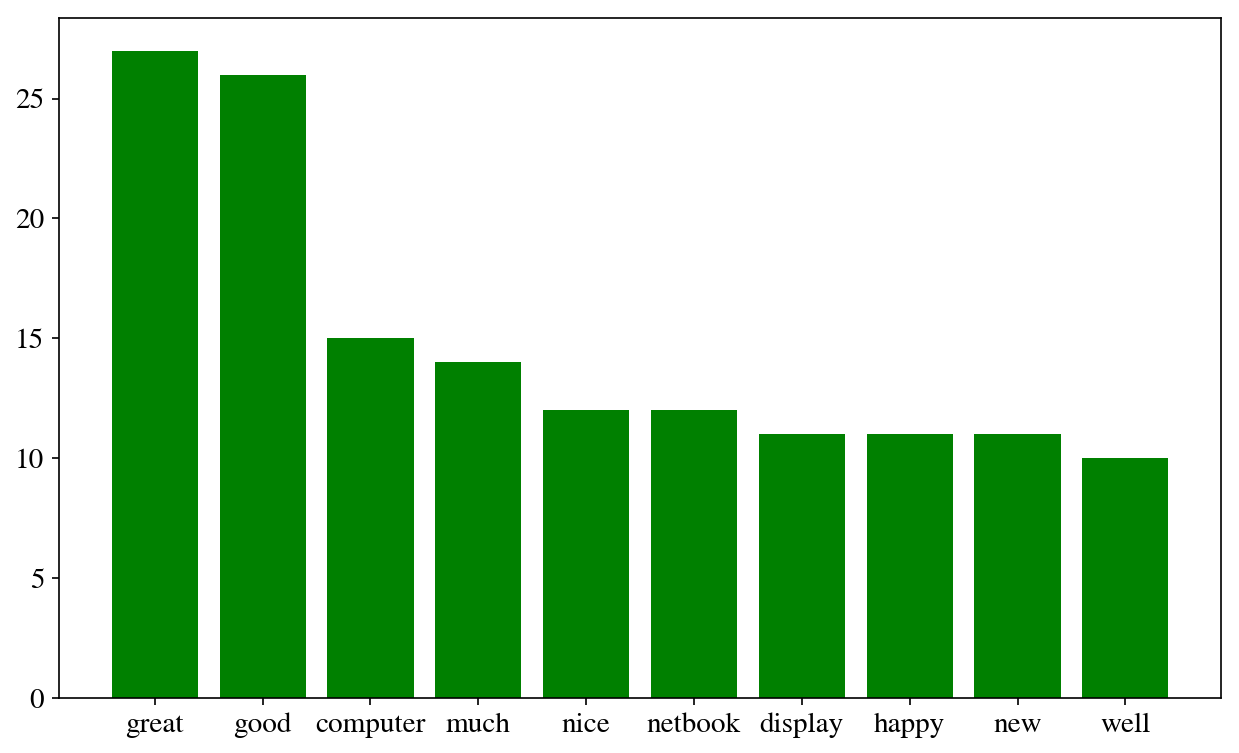

In [70]:
#Positive word count barchart.

Top10_Positive = Positive_Word_Count.head(10) # Get the top 10 most frequent words.
x = np.arange(0,10,1) #Get arbitrary x axis values.
y = Top10_Positive.Count.values #y axis will be the counts.
plt.bar(x,y,color = "green") # Create the bar plot with a green color, for positive.
plt.xticks(x,Top10_Positive.Word) # Replace arbitrary x values with the most common words.
plt.show()# Show the plot!

Looks like some of the words related to the product got through, but we'll let it slide for this one. The most positive words seem to be great, good, much, nice, happy, new and well. Looks like the reviewers love new computers and netbooks mostly! We can also combine some of the words with the technical words, to assume their combinations, like good computer, nice display, etc. 

Now let's do the same for the negative words.

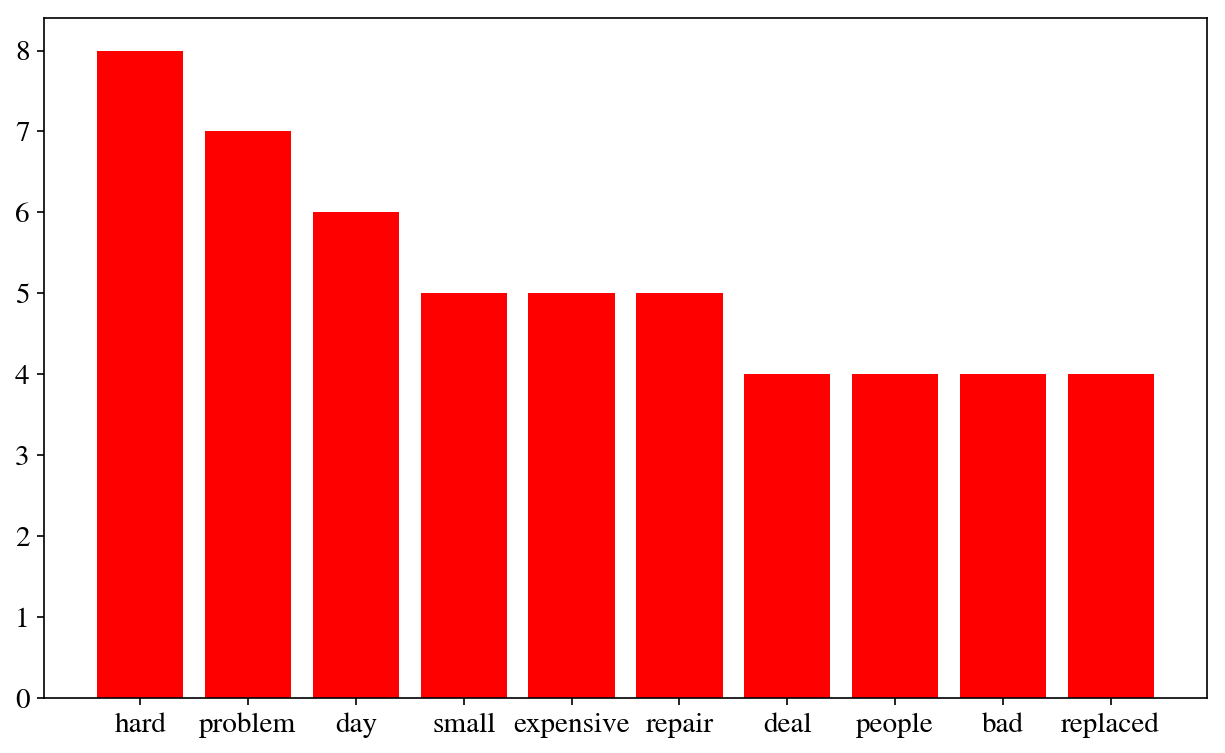

In [71]:
#Positive word count barchart.
Top10_Negative = Negative_Word_Count.head(10)
x = np.arange(0,10,1)
y = Top10_Negative.Count.values
plt.bar(x,y,color = "red")
plt.xticks(x,Top10_Negative.Word)
plt.show()

The negative words are certainly more detailed. Looks like the customers don't like small or expensive computers the most. And customers really appreciate computer electronics that are simple, and not give any problems, or are hard to configure or setup. It also looks like some computers were actually in need of repair, or had to be replaced. Maybe they are buying expensive computers that get easily broken or create a negative experience. 

Now, let's plot the most common words. First, we have to sum the counts of when they appear in both positive and negative reviews, and sort them.

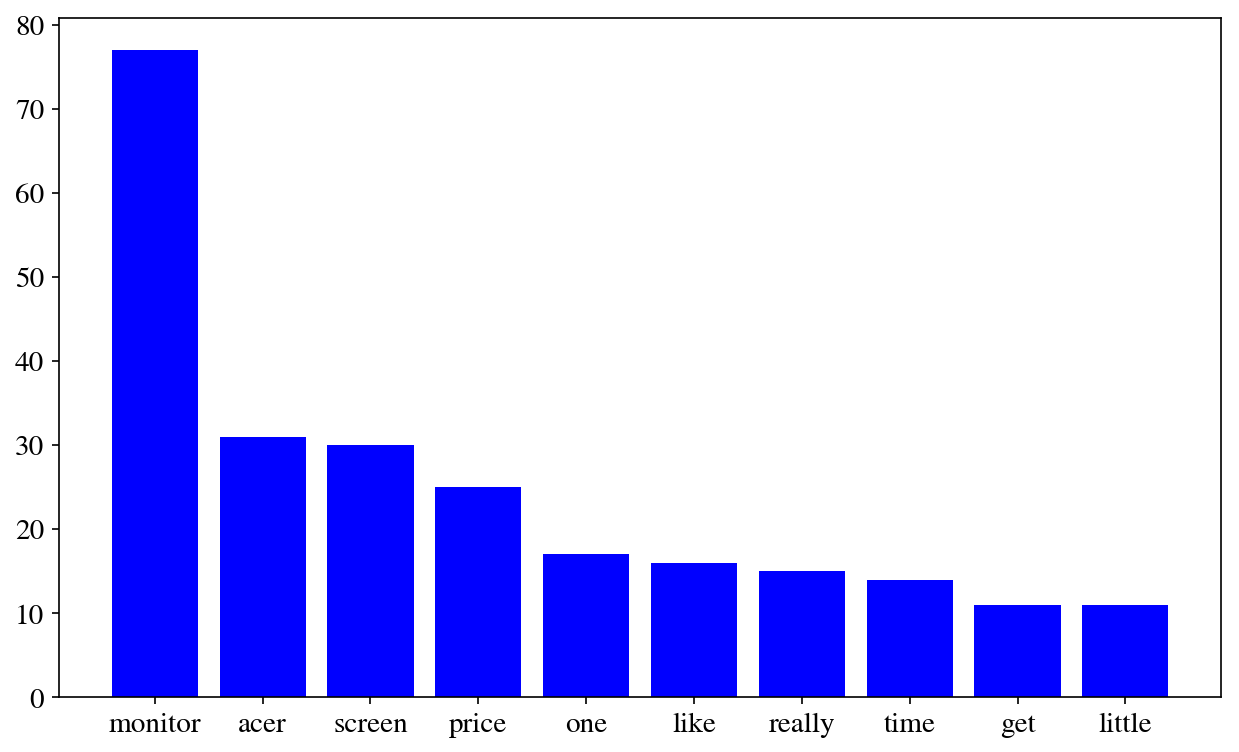

In [72]:
Common_Words["Total_Count"] = Common_Words.Count_x + Common_Words.Count_y #Sum counts of negatives and positives.
Common_Words = Common_Words.sort_values(by = "Total_Count",ascending = False) #Sort by total count.
#Plot it.
x = np.arange(0,10,1)
y = Common_Words.head(10).Total_Count.values
plt.bar(x,y,color = "blue")
plt.xticks(x,Common_Words.Word)
plt.show()


As we can see, the common words don't give us that much information about what words influence the sentimentality of a review. However, it gives us insight about what customers look for the most on these products. For example, monitors(and screens by association) are a very important part of the reviews, since they are the most mentioned word by far. Customers are alsot worried about the price. One brand that shows up commonly is the acer brand, so this brand must be the most popular on the reviews, and that's not strange, since they do sell laptops, monitors and other electronics.

Now let's do some summary statistics on the word counts.

In [73]:
count_dict = {"Positive":Positive_Word_Count.Count.describe(),
              "Negative":Negative_Word_Count.Count.describe(),
              "Common_Count":Common_Words.Total_Count.describe()}
Word_Counts = pd.DataFrame(count_dict)
Word_Counts

Common_Count    Negative    Positive
count     16.000000  507.000000  948.000000
mean      18.687500    1.358974    1.965190
std       17.300169    0.805940    2.088297
min        8.000000    1.000000    1.000000
25%        9.000000    1.000000    1.000000
50%       12.500000    1.000000    1.000000
75%       19.000000    1.000000    2.000000
max       77.000000    8.000000   27.000000

Good news! Positive words outnumber negative ones by almost double the amount. Looks like there are not many common words (that appear frequently) between the two sentiments. However, the standard deviation is huge for the common word count(almost the same as the mean), and this is mostly because of one huge outlier, monitors. The mean of word counts for negative words is close to 1, while for negative words it's closer to two. The standard deviation is also huge for both sentimental counts, mostly becaue there are a lot of words, but most appearly only once. Let's try to visualize the summary statistics one more time, but without words that appear so infrequently.

In [74]:
#Eliminate rows with uncommon words.
Frequent_Positives = Positive_Word_Count.loc[Positive_Word_Count.Count > 2]
Frequent_Negatives = Negative_Word_Count.loc[Negative_Word_Count.Count > 2]

#Create a new dict and dataframe with the summary statistics.
frequent_count_dict = {"Positive":Frequent_Positives.Count.describe(),
                       "Negative":Frequent_Negatives.Count.describe(),
                       "Common_Count":Common_Words.Total_Count.describe()}

Frequent_Counts = pd.DataFrame(frequent_count_dict)
Frequent_Counts

Common_Count   Negative    Positive
count     16.000000  38.000000  186.000000
mean      18.687500   3.605263    4.973118
std       17.300169   1.197734    3.205456
min        8.000000   3.000000    3.000000
25%        9.000000   3.000000    3.000000
50%       12.500000   3.000000    4.000000
75%       19.000000   4.000000    6.000000
max       77.000000   8.000000   27.000000

That really cut the numbers down. Still the concentration of words lies in lower values, so that hasn't changed. And, positive words still have a higher spread of values than negative words (and much more counts), so there are more positive words in the reviews, than negative ones.

## 4. Pairs of words.

Now, let's do a similar analysis to the one above, but for pairs of words, and without eliminating the most common words. This is to see if we can find combinations like (bad, monitor), (good, computer) and the like. To do this, we'll create a function Get_Pairs, which gets all unique combinations of pairs of words on reviews, and counts them. This time, we'll not worry about common or uncommon words.

In [75]:
def Get_Pairs(dataframe):
    #Get the word pair count for a particular dataframe.
    result = {}
    #Iterate through words of the review
    for words in dataframe.Review:
        #Check if a pair is already in the dictionary. If it is add 1 to the counter, else add it to the dict.
        for pair in list(itertools.combinations(words.split(), 2)): #Get all different combinations.
            if pair[0] != pair[1]:#Determine if it's not the same words repeated twice.
                if pair not in result :
                    result[pair]= 1
                else:
                    result[pair]+=1
    #Convert dictionary to a dataframe, for better plotting.
    df = pd.DataFrame({"Pairs": list(result.keys()),"Count":list(result.values())})
    #Sort by count.
    return df.sort_values(by="Count",ascending=False)

PosWord_Pairs = Get_Pairs((Labeled_Reviews.loc[Labeled_Reviews.Sentiment=="positive"]))
NegWord_Pairs = Get_Pairs((Labeled_Reviews.loc[Labeled_Reviews.Sentiment=="negative"]))

With that out of the way, lets do some plotting again!

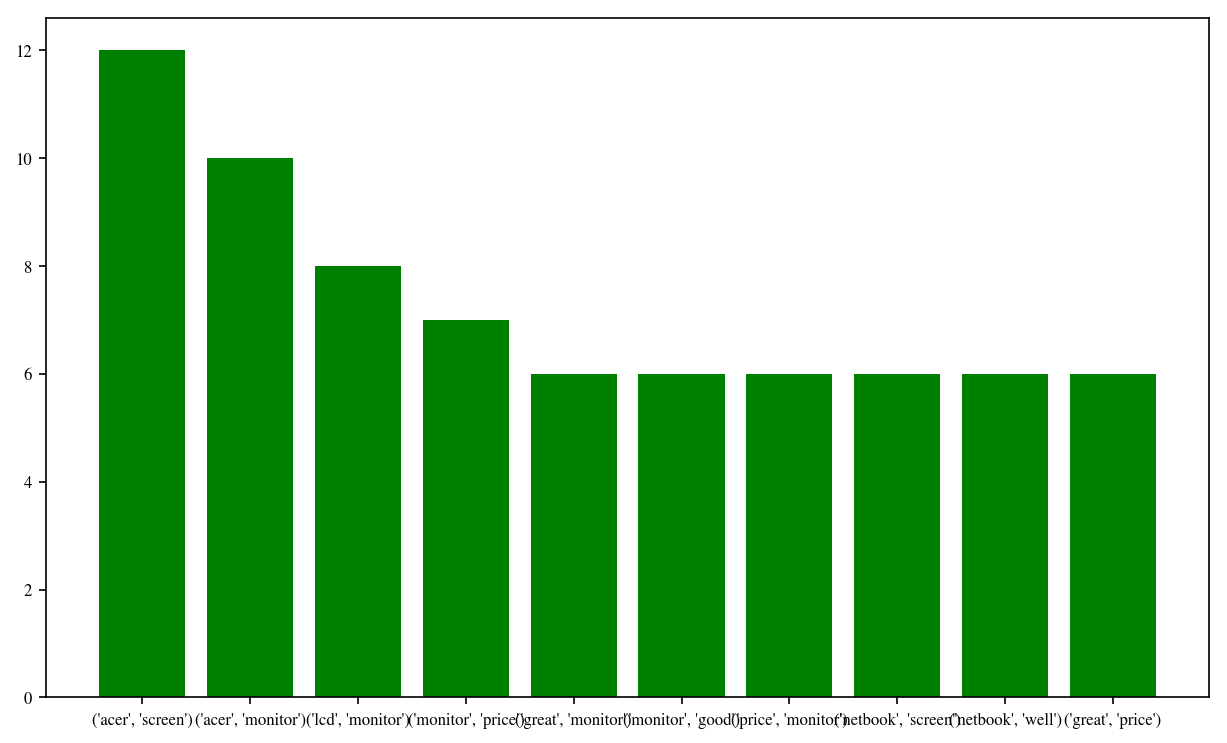

In [79]:
rcParams['font.size'] = 8 # Make the text smaller
Top10_PosPairs = PosWord_Pairs.head(10) # Get the top 10 most frequent pairs.
x = np.arange(0,10,1) #Get arbitrary x axis values.
y = Top10_PosPairs.Count.values #y axis will be the counts.
plt.bar(x,y,color = "green") # Create the bar plot with a green color, for positive.
plt.xticks(x,Top10_PosPairs.Pairs) # Replace arbitrary x values with the most common words.
plt.show()# Show the plot!

And now let's plot the negative ones, for comparison.

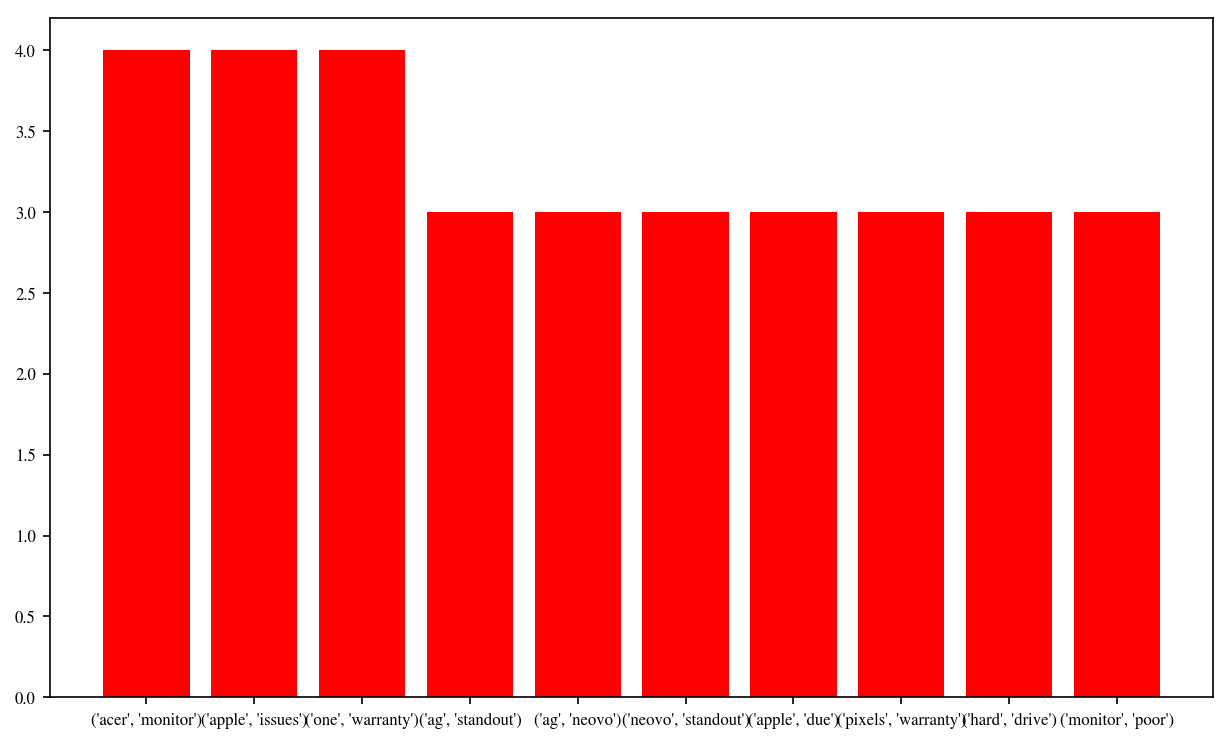

In [77]:
Top10_NegPairs = NegWord_Pairs.head(10) # Get the top 10 most frequent pairs.
x = np.arange(0,10,1) #Get arbitrary x axis values.
y = Top10_NegPairs.Count.values #y axis will be the counts.
plt.bar(x,y,color = "red") # Create the bar plot with a green color, for positive.
plt.xticks(x,Top10_NegPairs.Pairs) # Replace arbitrary x values with the most common words.
rcParams['font.size'] = 8 # Make the text smaller
plt.show()# Show the plot!

So, the most common word pair in both types of reviews is acer monitors!. Looks like they are the most frequently bought products. However, two companies stand out in the negative pairs, and those are Ag Neovo monitors, and Apple products. Looks like customers aren't too happy with these two companies products. However, in the positive pairs, acer monitors appear much more frequently than in the negative pairs, so acer monitors are overall positive for customers. Also, most customers speak well of monitors, so it seems that they care about display screens the most, since they are mentioned positively so often. And of other qualities, customers talk a lot about **price** , so price is a big factor for them.

## Conclusion

In conclusion, customers care a lot about the price and the quality of their monitors, more than anything else, out of the reviews provided. Of these, acer products are the most popular, both in the negative and positive reviews, although the positive counts outweigh the negative ones by far. On the other side of the spectrum, Apple and Ag Neovo need to improve the quality of their products, as customers don't have pretty words for them. Overall, there were more positive reviews than negative ones on the dataset, which means customers are liking the product selection that is offered right now on this sample of reviews, although improvements could be made.